In [ ]:
#|hide
%pip install -Uqq pandas seaborn ds_tut

import ds_tut
ds_tut.setup()

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd

import pickle

from pathlib import Path

import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline
import matplotlib.pyplot as plt

# Text Classification (Reuters-21578)

## Additional Information About the Dataset

- [Paper comparing different text categorization methods](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf) (Thorsten Joachims 1998)
- [Dataset Readme](http://www.daviddlewis.com/resources/testcollections/reuters21578/readme.txt)
- [Link to Dataset Card on Hugging Face](https://huggingface.co/datasets/reuters21578)

Maybe just use the dataset from Hugging Face instead of downloading and parsing manually? TODO

## Prepare Dataset

### Download

In [ ]:
#|notest
from ds_tut import download_from_url

archive_name = "reuters21578.tar.gz"
training_data_url = "http://www.daviddlewis.com/resources/testcollections/reuters21578/{}".format(archive_name)
data_root = Path.cwd() / "data" / "tmp"
data_root.mkdir(parents=True, exist_ok=True)
training_data_path = data_root / archive_name
reuters_dir = data_root / archive_name.split(".")[0]
data_size = download_from_url(training_data_url, training_data_path)

### Unpack

In [ ]:
#|notest
import tarfile

tar = tarfile.open(str(training_data_path))
tar.extractall(path=str(reuters_dir))
tar.close()

### Parse

In [ ]:
#|notest
import pickle

from ds_tut.datasets import ReutersParser, ReutersCorpus

documents = []
rp = ReutersParser()
for sgml_path in reuters_dir.glob("*.sgm"):
    for doc in rp.parse_sgml(str(sgml_path)):
        doc["filename"] = sgml_path
        documents.append(doc)

pickle_path = reuters_dir / "documents.pkl"
with open(str(pickle_path), "wb") as f:
    pickle.dump(documents, f)

reuters = ReutersCorpus(documents)

pickle_path = reuters_dir / "corpus.pkl"
with open(str(pickle_path), "wb") as f:
    pickle.dump(reuters, f)

## Explore Reuters-21578

### Load dataset

In [ ]:
#|notest
from ds_tut.datasets import ReutersCorpus

data_root = Path.cwd() / "data" / "tmp"
reuters_documents_path = data_root / "reuters21578" / "documents.pkl"
reuters_corpus_path = data_root / "reuters21578" / "corpus.pkl"

documents = pickle.load(open(reuters_documents_path, "rb"))
reuters = pickle.load(open(reuters_corpus_path, "rb"))
df, top_ten_ids, train_labels, test_labels = reuters.build_dataframe(pd=pd)
train, test = reuters.split_modapte()

## Get some simple stats

In [ ]:
#|notest
number_of_samples = reuters.number_of_samples
number_of_classes = reuters.number_of_classes
number_of_samples_per_class = int(np.average([tc for tc in reuters.topic_counts.values() if tc > 1]))
number_of_words_per_sample = int(np.median([len(d["text"].split()) for d in reuters.docs]))
samples_to_words_per_sample_ratio = int(number_of_samples / number_of_words_per_sample)

In [ ]:
#|notest
nchars = 52
print("Number of samples:".ljust(nchars), reuters.number_of_samples)
print("Number of classes:".ljust(nchars), reuters.number_of_classes)
print("Number of samples per class:".ljust(nchars), number_of_samples_per_class)
print("Number of words per sample:".ljust(nchars), number_of_words_per_sample)
print("Number of samples/number of words per sample ratio:".ljust(nchars), samples_to_words_per_sample_ratio)

Number of samples:                                   10789
Number of classes:                                   119
Number of samples per class:                         148
Number of words per sample:                          89
Number of samples/number of words per sample ratio:  121


## Distribution of sample length for reuters21578

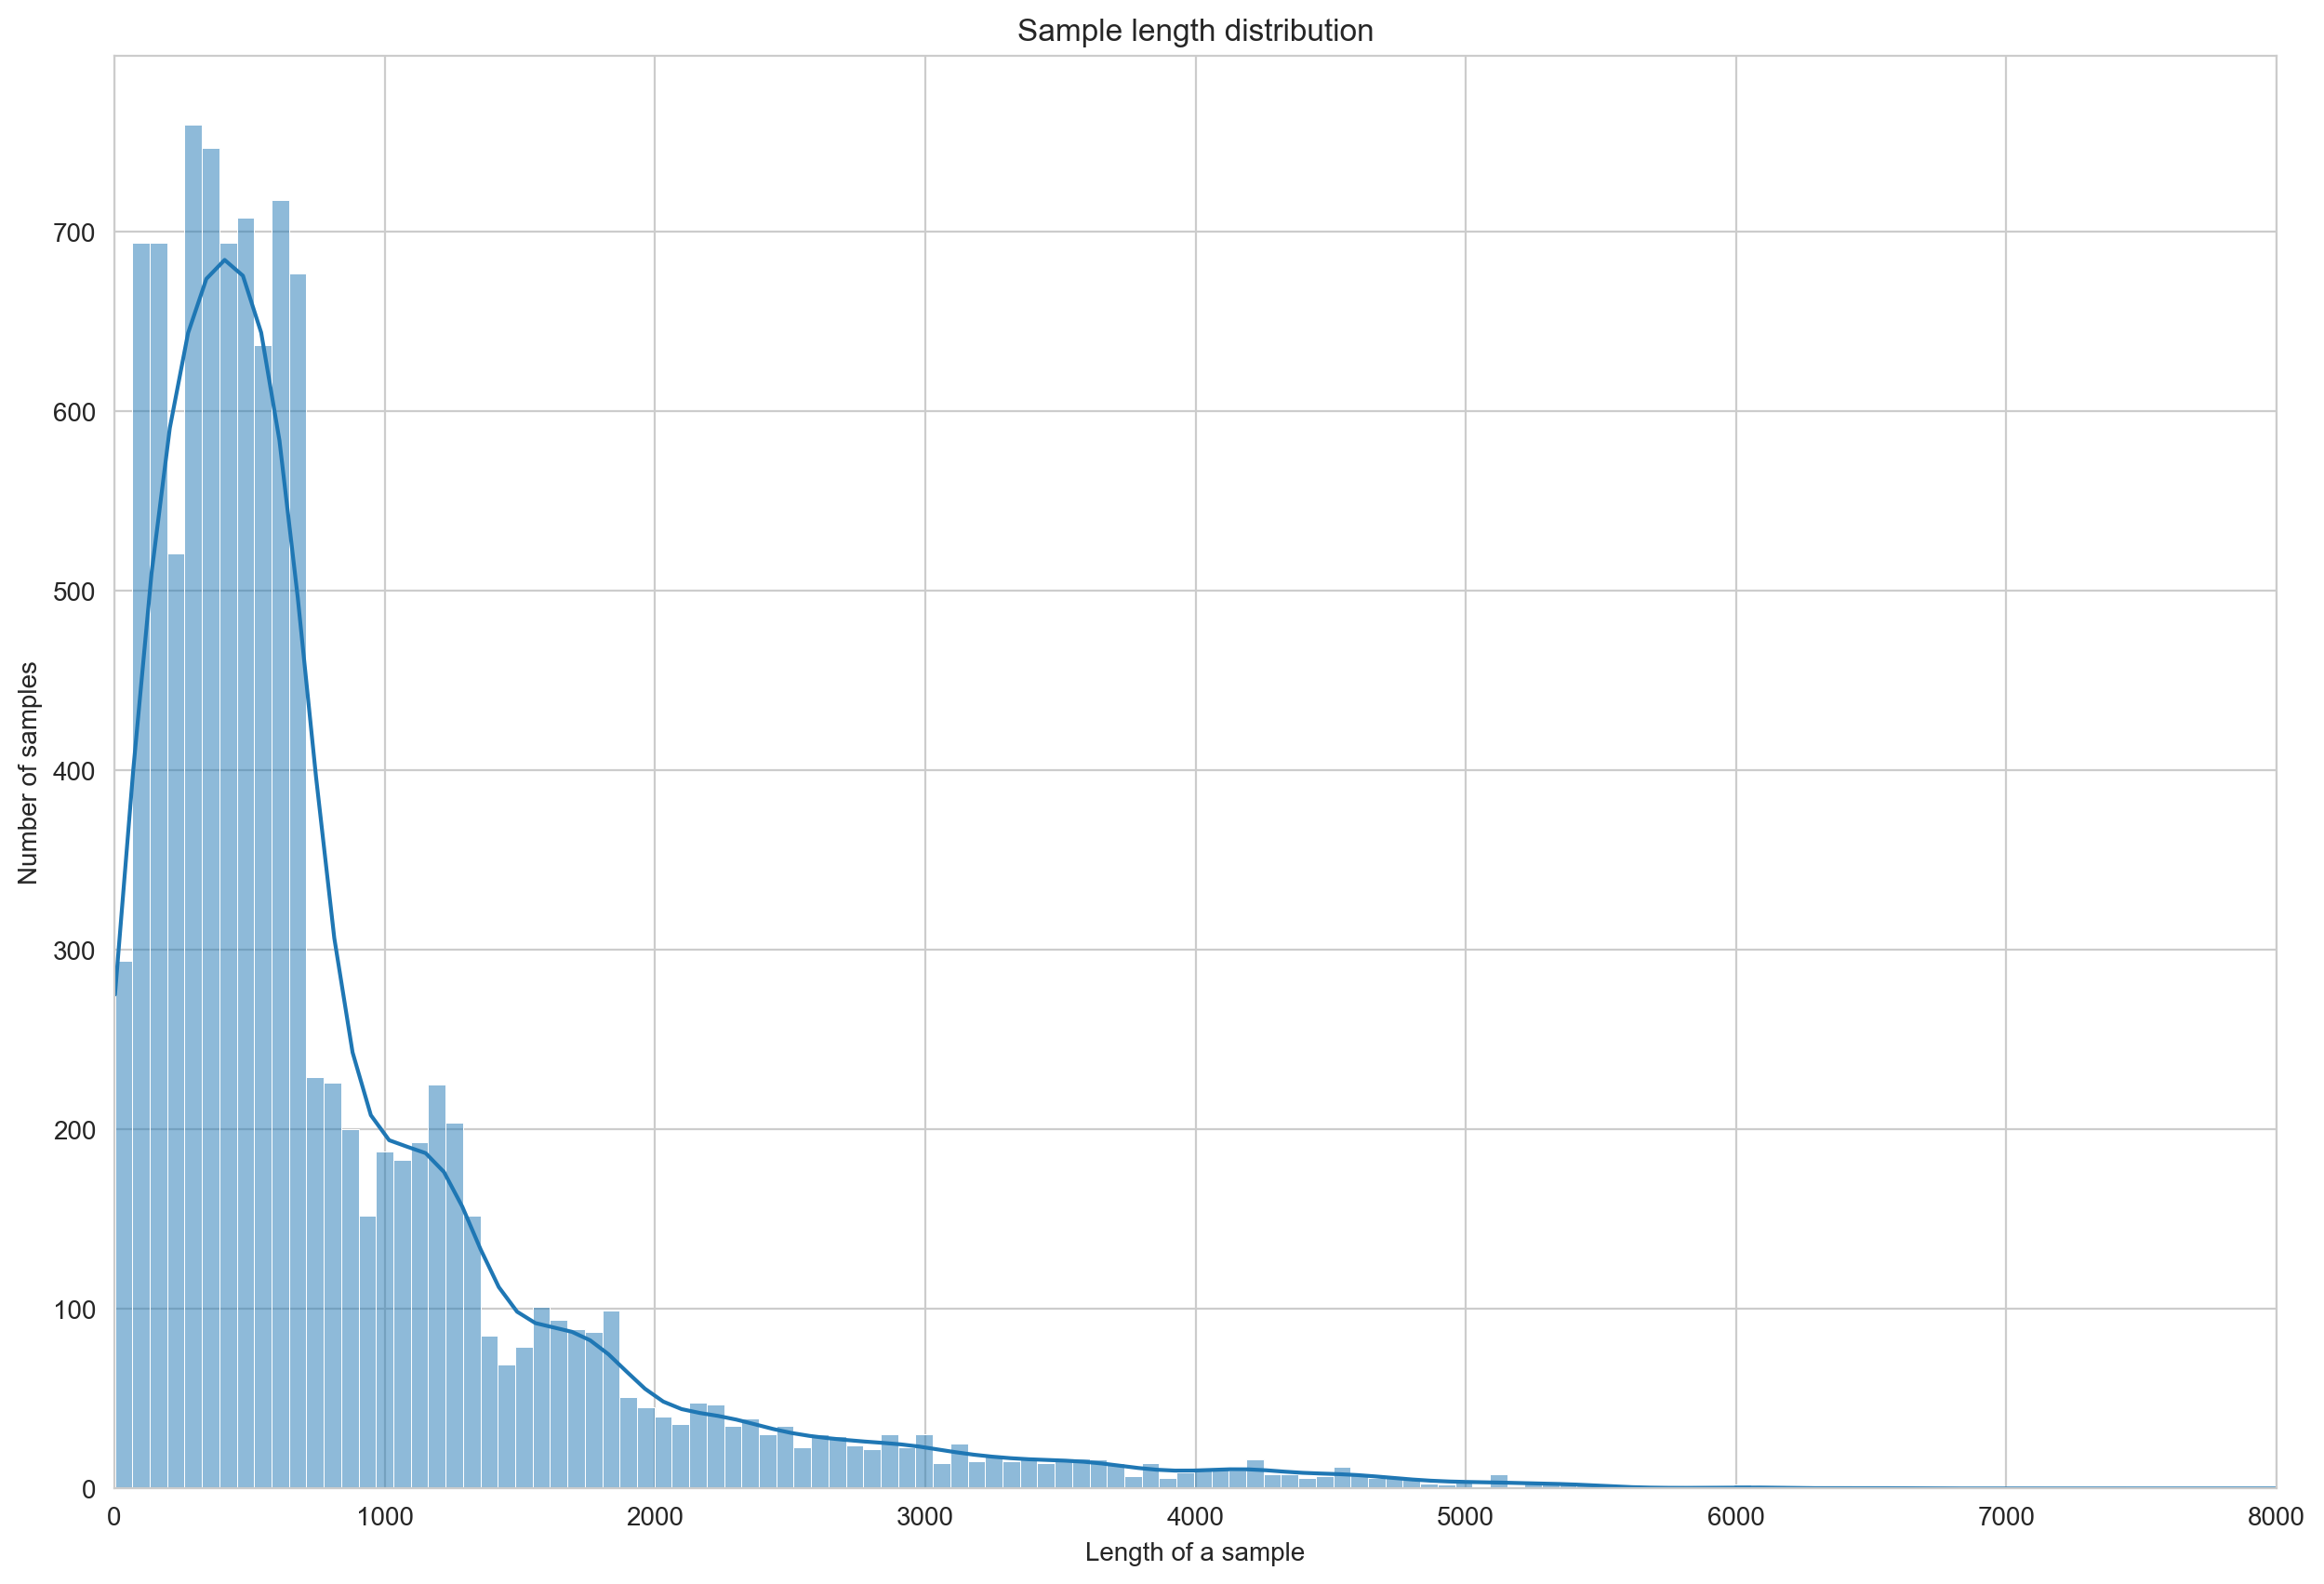

In [ ]:
#|notest
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot([len(d["text"]) for d in reuters.docs], kde=True, ax=ax)
ax.set_title('Sample length distribution')
ax.set_xlabel('Length of a sample')
ax.set_xlim(0, 8000)
_ = ax.set_ylabel('Number of samples')

## Word frequency distribution

In [ ]:
%pip install -Uqq scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#|notest
from sklearn.feature_extraction.text import CountVectorizer

kwargs = {
        'ngram_range': (1, 1),
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',  # Split text into word tokens.
}
vectorizer = CountVectorizer(**kwargs)
vectorized_texts = vectorizer.fit_transform(reuters.texts)
all_ngrams = list(vectorizer.get_feature_names_out())
all_counts = vectorized_texts.sum(axis=0).tolist()[0]
all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
    zip(all_counts, all_ngrams), reverse=True)])

num_ngrams=50
ngrams = list(all_ngrams)[:num_ngrams]
counts = list(all_counts)[:num_ngrams]
idx = np.arange(num_ngrams)

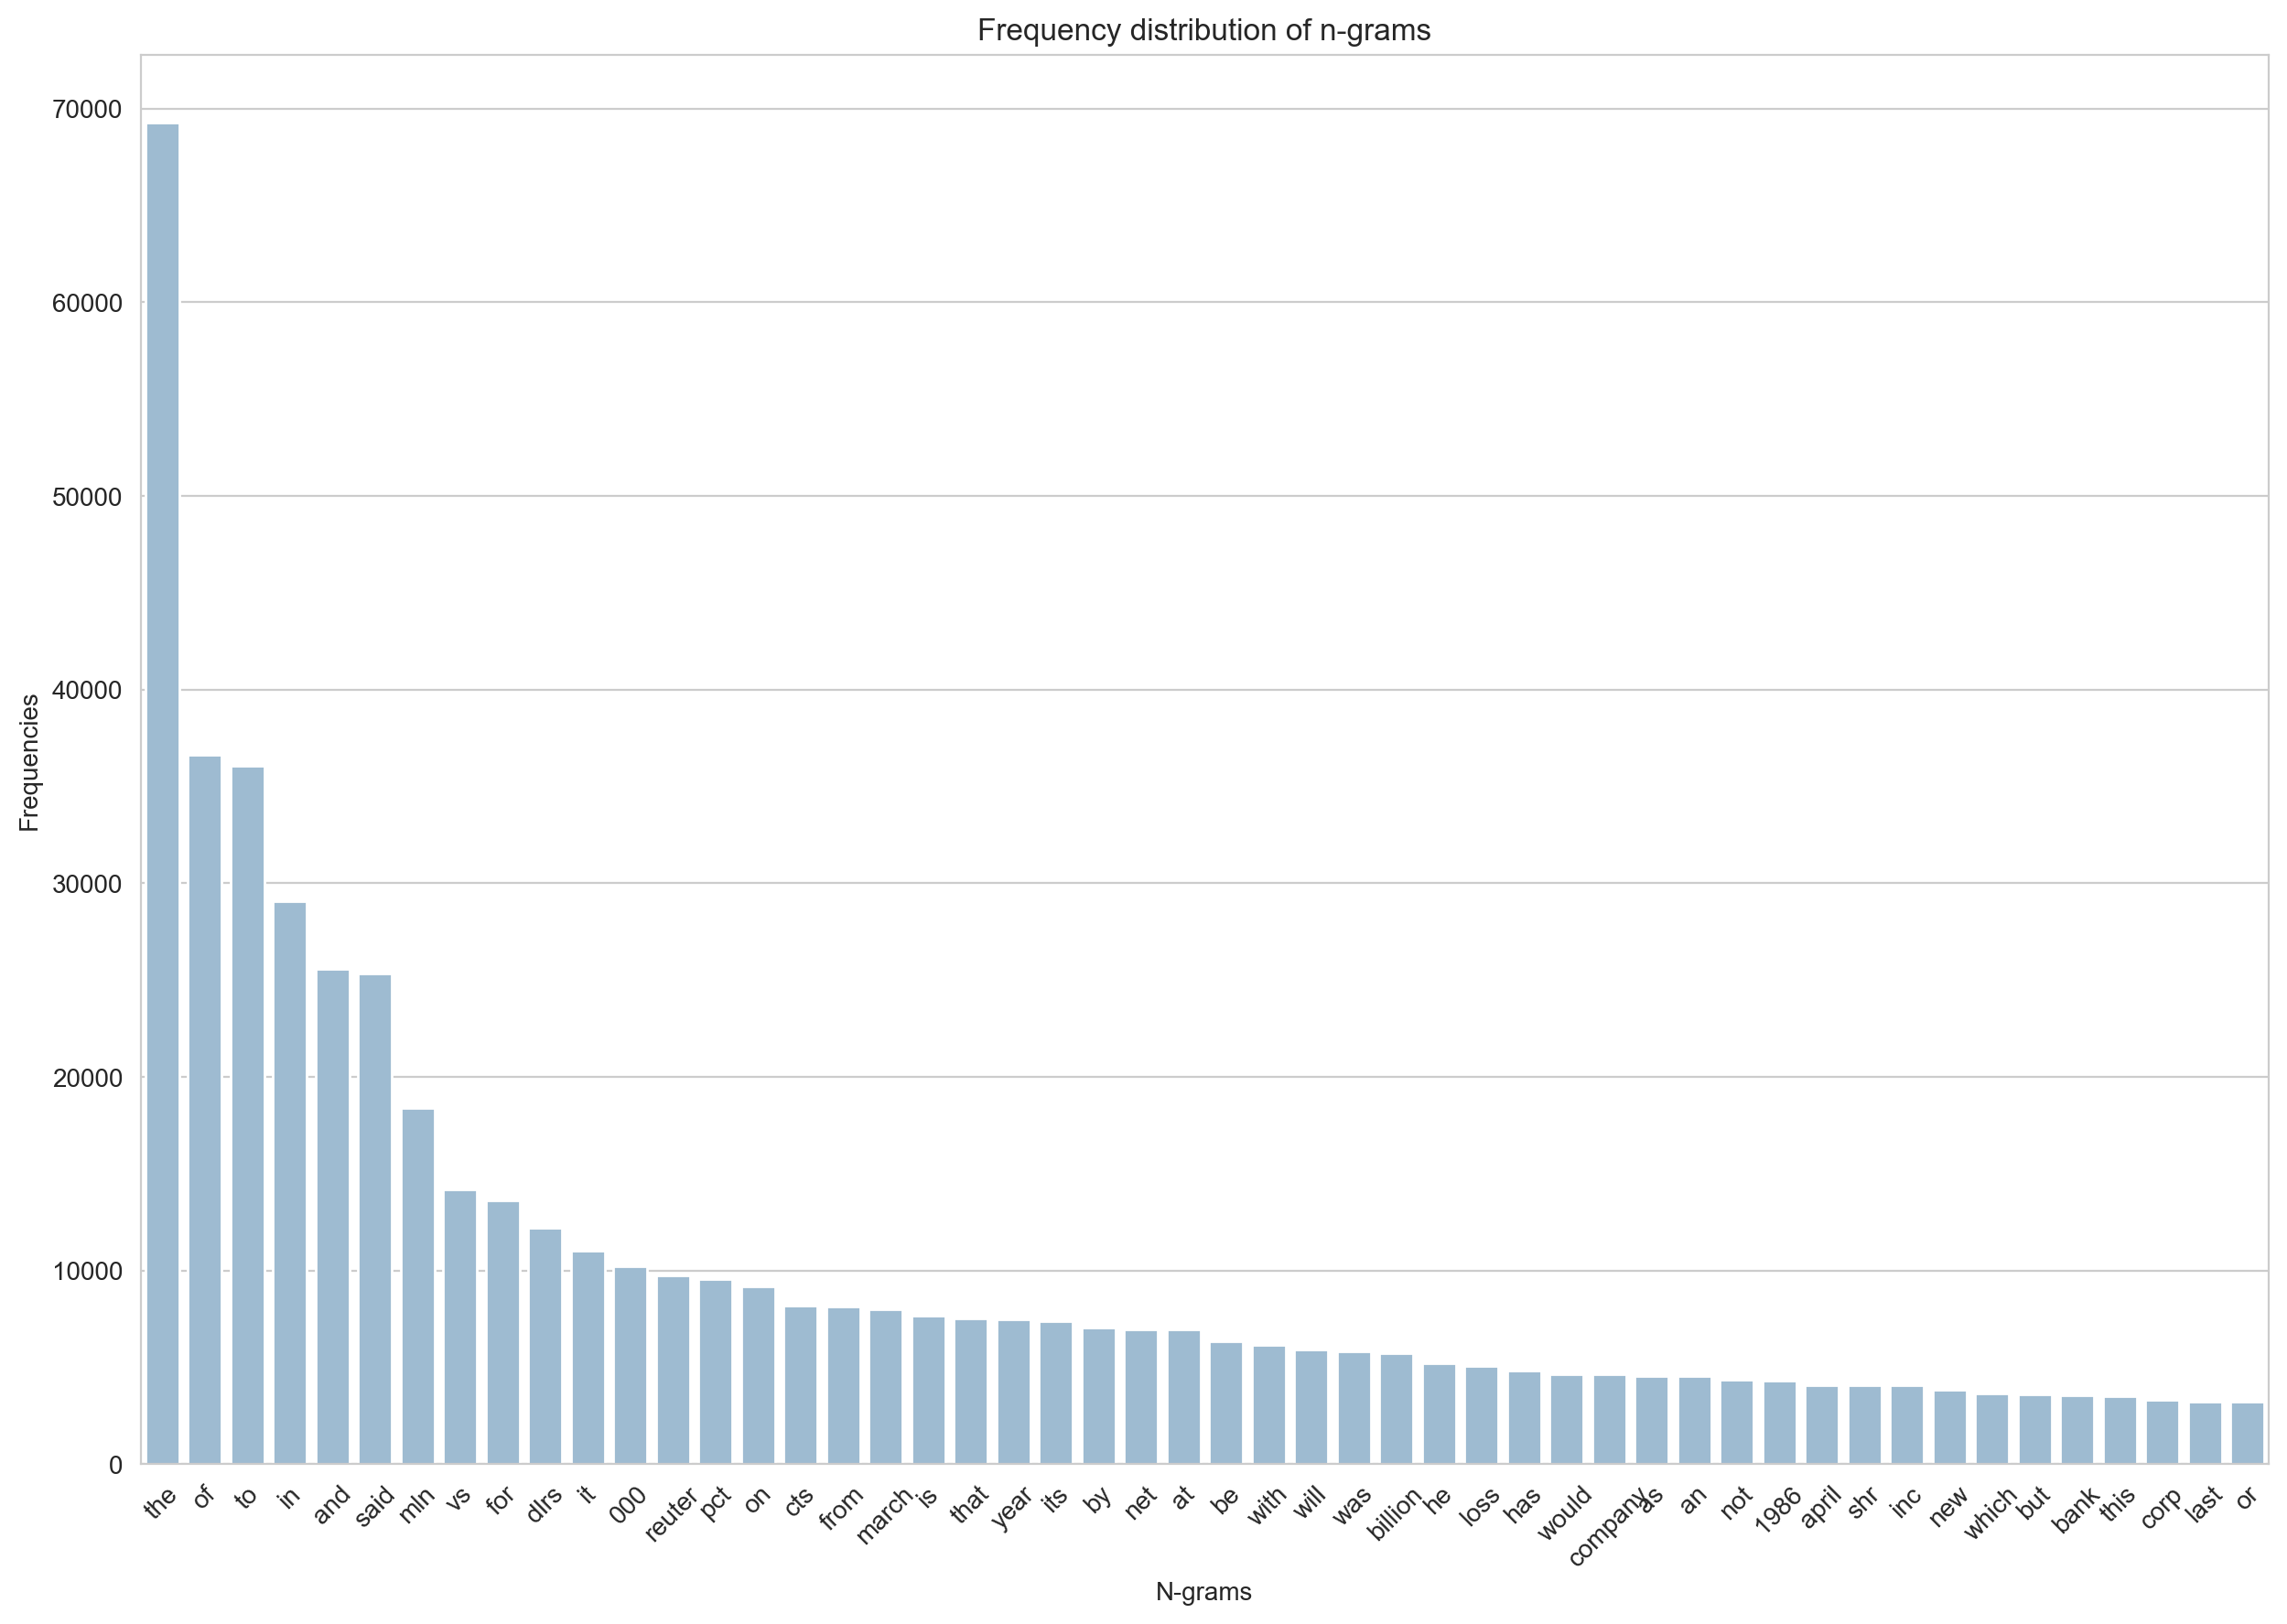

In [ ]:
#|notest
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=ngrams, y=counts, ax=ax, color="#95BCD9")
ax.set_title('Sample length distribution')
plt.xlabel('N-grams')
_ = plt.ylabel('Frequencies')
_ = plt.title('Frequency distribution of n-grams')
_ = plt.xticks(idx, ngrams, rotation=45)

## Choose a model flowchart

In [ ]:
#|notest
from IPython.display import display, HTML
url = "https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png"
html_code = f"""
<div>
    <p>Number of samples/number of words per sample ratio: {samples_to_words_per_sample_ratio}</p>
    <img src="{url}" style="width: 100%">
</div>
"""
display(HTML(html_code))

## Simple Linear Model

Ok, pretty impressive image. How about to try just a very simple linear model?

### Get text and labels

In [ ]:
#|notest
from sklearn.preprocessing import MultiLabelBinarizer

train_docs, test_docs = reuters.split_modapte()
print(len(train_docs), len(test_docs))

train = [d["text"] for d in train_docs]
train_labels = reuters.get_labels(train_docs)
y_train = MultiLabelBinarizer().fit_transform(train_labels)

test = [d["text"] for d in test_docs]
test_labels = reuters.get_labels(test_docs)
y_test = MultiLabelBinarizer().fit_transform(test_labels)

7770 3019


### Vectorize Texts

In [ ]:
#|notest
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(train)

X_train = vectorizer.transform(train)
X_test = vectorizer.transform(test)

### Evaluate Models

In [ ]:
#|notest
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

top_ten_ids, top_ten_names = reuters.top_n(n=10)

#### Logistic Regression

This is usually one of the first models to try. Simple, robust, fast, elegant. One of the best baseline methods.

In [ ]:
#|notest
from sklearn.linear_model import LogisticRegression
# model = OneVsRestClassifier(LogisticRegression(C=100, solver="liblinear", multi_class="ovr"))
model = OneVsRestClassifier(LogisticRegression(solver="liblinear", multi_class="ovr"))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, zero_division=0.0))

              precision    recall  f1-score   support

        earn       0.99      0.97      0.98      1087
         acq       0.98      0.92      0.95       719
    money-fx       0.78      0.51      0.62       179
       grain       0.99      0.60      0.75       149
       crude       0.96      0.57      0.72       189
       trade       0.93      0.54      0.68       117
    interest       0.91      0.47      0.62       131
        ship       1.00      0.13      0.24        89
       wheat       0.97      0.51      0.67        71
        corn       0.95      0.32      0.48        56

   micro avg       0.97      0.79      0.87      2787
   macro avg       0.95      0.56      0.67      2787
weighted avg       0.97      0.79      0.85      2787
 samples avg       0.70      0.69      0.69      2787



#### Linear Support Vector Machine

In [ ]:
#|notest
from sklearn.svm import LinearSVC
model = OneVsRestClassifier(LinearSVC(dual=True))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3, zero_division=0.0))

              precision    recall  f1-score   support

        earn      0.991     0.980     0.985      1087
         acq      0.984     0.950     0.967       719
    money-fx      0.810     0.788     0.799       179
       grain      0.975     0.799     0.878       149
       crude      0.906     0.868     0.886       189
       trade      0.830     0.709     0.765       117
    interest      0.870     0.664     0.753       131
        ship      0.924     0.685     0.787        89
       wheat      0.929     0.732     0.819        71
        corn      0.955     0.750     0.840        56

   micro avg      0.956     0.896     0.925      2787
   macro avg      0.917     0.793     0.848      2787
weighted avg      0.954     0.896     0.922      2787
 samples avg      0.771     0.769     0.767      2787



### Precision/Recall-Curve

One way to visualize the performance of a classifier.

In [ ]:
#|notest
df_train = df.query("modapte == 'train'")
df_test = df.query("modapte == 'test'")

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train.label)
y_test = mlb.transform(df_test.label)
print(df_train.shape, df_test.shape)

cache_dir = reuters_dir / "cache"

(7770, 9) (3019, 9)


In [ ]:
#|notest
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler

from ds_tut.transformers import TextFromColumns, TextStats, ColumnSelector, TextFromColumns2

pipeline = Pipeline(
    memory=str(cache_dir),
    steps=[
        ("union", FeatureUnion(n_jobs=1, transformer_list=[
            ("title_stats", Pipeline([
                ("column", ColumnSelector("title")),
                ("stats", TextStats()),
                ("scaled", StandardScaler()),
            ])),
            ("body_stats", Pipeline([
                ("column", ColumnSelector("body")),
                ("stats", TextStats()),
                ("scaled", StandardScaler()),
            ])),
            ("combined_text", Pipeline([
                ("column", TextFromColumns2()),
                ("tfidf", TfidfVectorizer()),
            ])),
        ])),
        ("clf", OneVsRestClassifier(LinearSVC(C=1, dual=True, max_iter=20000))),
])

In [ ]:
#|notest
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(df_train.label)
y_test_transformed = mlb.transform(df_test.label)
pipeline.fit(df_train, y_train)
y_pred = pipeline.predict(df_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3, zero_division=0.0))

              precision    recall  f1-score   support

        earn      0.990     0.980     0.985      1087
         acq      0.980     0.949     0.964       719
    money-fx      0.799     0.777     0.788       179
       grain      0.977     0.852     0.910       149
       crude      0.899     0.852     0.875       189
       trade      0.827     0.692     0.753       117
    interest      0.880     0.672     0.762       131
        ship      0.919     0.640     0.755        89
       wheat      0.917     0.775     0.840        71
        corn      0.957     0.786     0.863        56

   micro avg      0.953     0.897     0.924      2787
   macro avg      0.914     0.797     0.849      2787
weighted avg      0.951     0.897     0.922      2787
 samples avg      0.770     0.768     0.766      2787



In [ ]:
#|notest
y_score = pipeline.decision_function(df_test)

from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=list(range(y_score.shape[1])))

In [ ]:
#|notest
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision, recall, average_precision = {}, {}, {}
for i in range(y_score.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.93


In [ ]:
#|notest
# precision recall breakeven point
prbp = None
for num, (p, r) in enumerate(zip(precision["micro"], recall["micro"])):
    if p == r:
        print(num, p, r)
        prbp = p

265509 0.8760683760683761 0.8760683760683761


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.93')

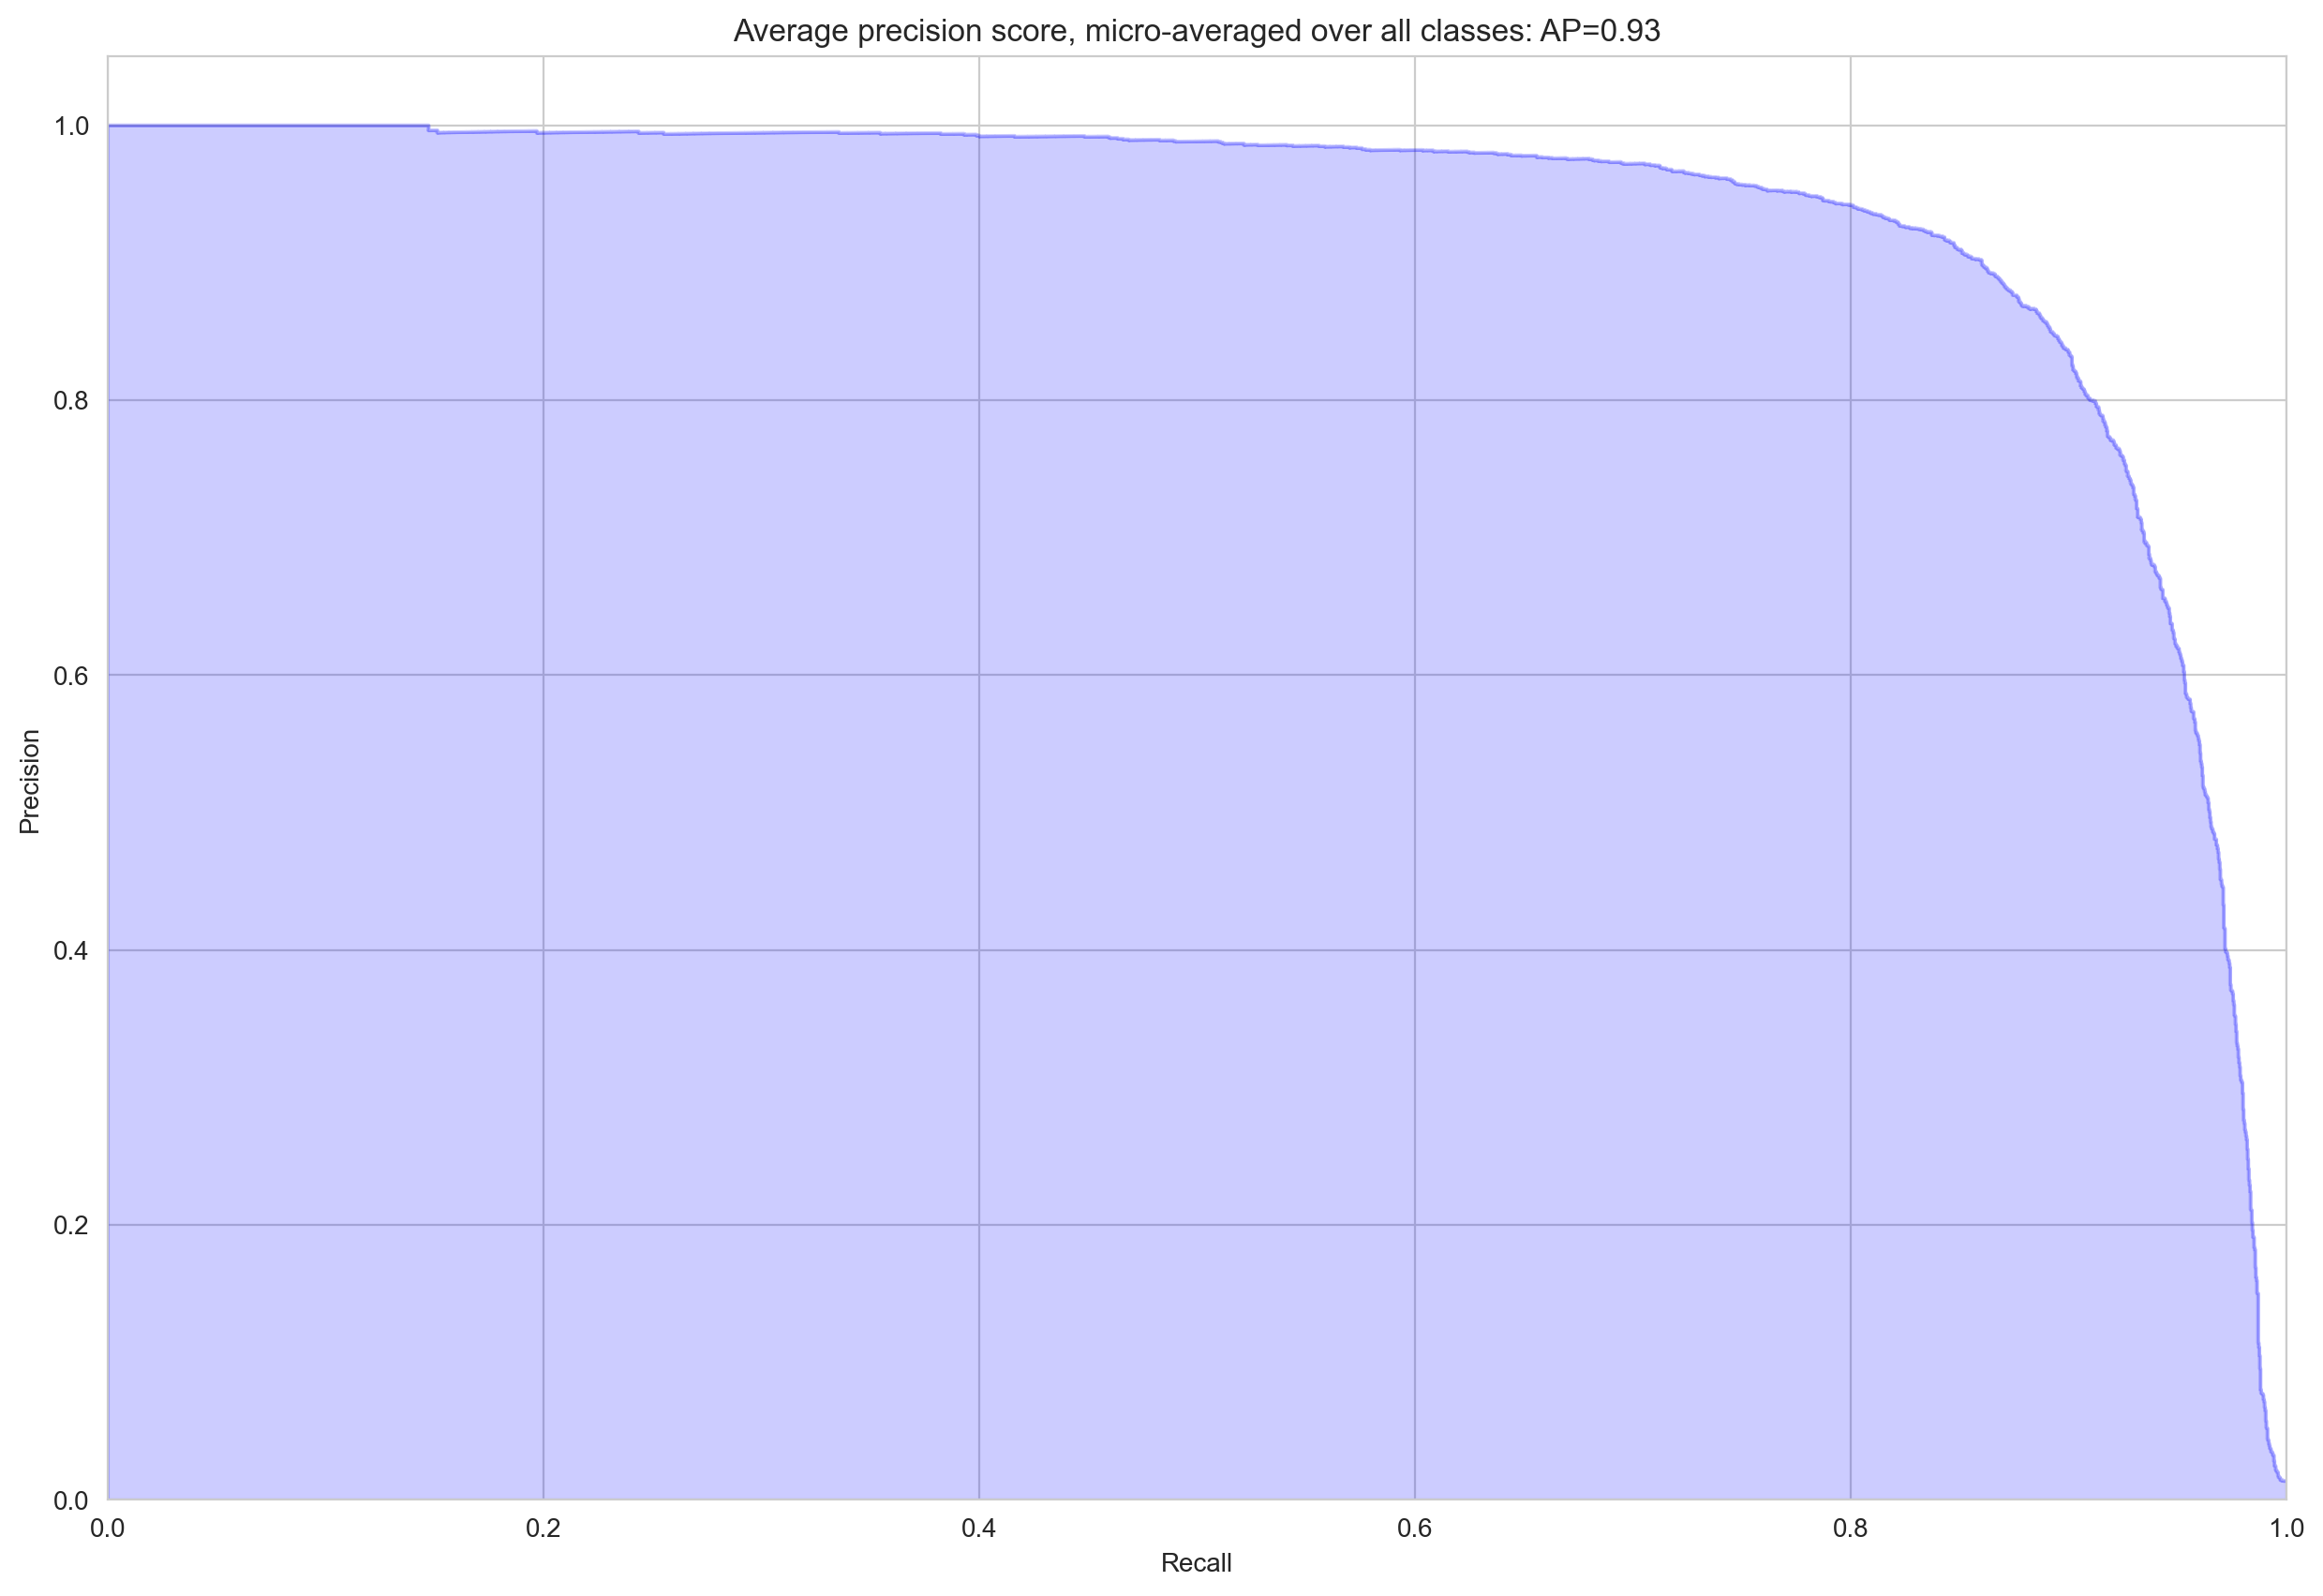

In [ ]:
#|notest
plt.figure(figsize=(15, 10))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))